In [118]:
## !pip install obspy
## !pip install geopy
## !pip install scikit-learn

In [119]:
from obspy.clients.fdsn import Client
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting


def get_geolocation(city="Challis, ID"):
    """Fetch the latitude and longitude of a city."""
    geolocator = Nominatim(user_agent="TomPEQProject")
    try:
        loc = geolocator.geocode(city)
        if loc:
            return loc.latitude, loc.longitude
        else:
            print(f"City {city} not found.")
            return None
    except Exception as e:
        print(f"Error fetching geolocation for {city}: {e}")
        return None

def get_earthquake_data(client="USGS", city="Challis, ID", maxradius=1, starttime="1900-10-01", endtime="2024-10-11", minmagnitude=2.5):
    """Fetch earthquake events around a city."""
    lat, lon = get_geolocation(city)
    if lat is None or lon is None:
        return None

    try:
        catalog = client.get_events(starttime=starttime, 
                                endtime=endtime, 
                                minmagnitude=minmagnitude,
                                eventtype="earthquake",
                                latitude=lat,
                                longitude=lon,
                                maxradius=maxradius
                                )
        return catalog
    except Exception as e:
        print(f"Error fetching events: {e}")
        return None
    
def process_earthquake_data(catalog):
    """Process the fetched earthquake events and extract location information."""
    locs = []
    if catalog:
        for event in catalog:
            temp = event.origins[0]
            if temp.longitude is not None and temp.latitude is not None and temp.depth is not None:
                location = [temp.longitude, temp.latitude, temp.depth]  
                locs.append(location)
                print(f"Event Time: {temp.time}, Magnitude: {event.magnitudes[0].mag}")
                print(location)
        max_depth = max(locs, key=lambda x: x[2])[2]
    return np.array(locs), max_depth
    
def normalize_depth(locs):
    """Normalize the depth values."""
    scaler = MinMaxScaler()
    locs[:, 2] = -scaler.fit_transform(locs[:, 2].reshape(-1, 1)).flatten()
    return locs

city = "Challis, ID"
client = Client("USGS")
catalog = get_earthquake_data(client=client, city=city, maxradius=1)
if catalog:
    locs, max_depth = process_earthquake_data(catalog)
    locs = normalize_depth(locs)

Event Time: 2024-10-09T11:44:02.296000Z, Magnitude: 3.0
[-115.0431, 44.264, 10000.0]
Event Time: 2024-09-29T03:32:26.847000Z, Magnitude: 2.7
[-115.16, 44.3051, 5000.0]
Event Time: 2024-09-22T02:56:35.367000Z, Magnitude: 2.6
[-115.1344, 44.3234, 10000.0]
Event Time: 2024-09-11T02:52:43.153000Z, Magnitude: 3.1
[-114.8689, 44.3056, 14308.0]
Event Time: 2024-08-10T15:59:10.574000Z, Magnitude: 2.6
[-115.1726, 44.3643, 16674.0]
Event Time: 2024-08-04T21:30:36.813000Z, Magnitude: 3.2
[-115.1823, 44.3315, 10000.0]
Event Time: 2024-07-24T20:50:02.851000Z, Magnitude: 2.6
[-115.1597, 44.3575, 10000.0]
Event Time: 2024-07-02T23:45:50.120000Z, Magnitude: 2.5
[-115.567, 44.3954, 6203.0]
Event Time: 2024-06-23T00:26:28.087000Z, Magnitude: 2.8
[-115.1826, 44.3618, 19000.0]
Event Time: 2024-06-19T11:11:36.284000Z, Magnitude: 2.9
[-114.8591, 44.2975, 12617.0]
Event Time: 2024-06-07T17:30:30.066000Z, Magnitude: 2.7
[-115.1874, 44.3711, 10000.0]
Event Time: 2024-05-21T09:18:06.029000Z, Magnitude: 2.6
[-11

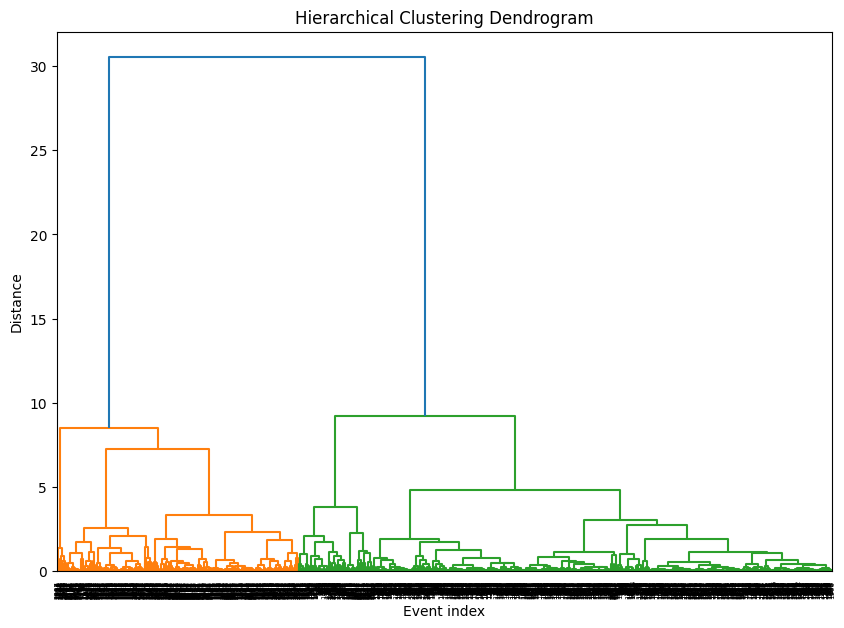

In [120]:
def perform_clustering(locs):
    """Perform hierarchical clustering on earthquake locations."""
    linked = linkage(locs, method='ward')
    return linked

def perform_labeling(linked, k):
    labels = fcluster(linked, k, criterion='maxclust')
    return labels

def plot_dendrogram(linked):
    """Plot the hierarchical clustering dendrogram."""
    plt.figure(figsize=(10, 7))
    dendro = dendrogram(linked)
    color_dict = {color for color in dendro['color_list']}
    num_colors = len(color_dict)
    
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Event index')
    plt.ylabel('Distance')
    plt.show()
    
    return num_colors - 1


linked = perform_clustering(locs)
k = plot_dendrogram(linked)
labels = perform_labeling(linked, k)

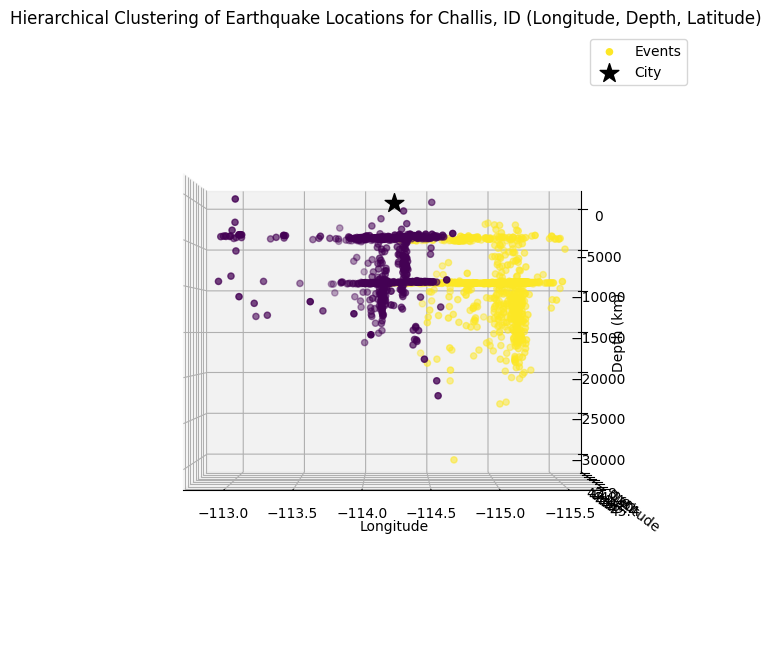

In [121]:
def plot_3d_clusters(locs, labels, city, max_depth, elev, azim):
    """Plot the 3D scatter plot of earthquake locations and clusters."""
    fig = plt.figure(figsize=(10,8))
    lat, lon = get_geolocation(city=city)

    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(locs[:, 0], locs[:, 1], locs[:, 2]*max_depth, c=labels, cmap='viridis', marker='o', label='Events')
    ax.scatter(lon, lat, 0, c='black', marker='*', s=200, label='City')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (km)')

    ax.set_title(f'Hierarchical Clustering of Earthquake Locations for {city} (Longitude, Depth, Latitude)')
    ax.legend()

    ax.view_init(elev=elev, azim=azim)

    plt.show()
    

plot_3d_clusters(locs, labels, city, max_depth, elev=0, azim=90)